'lorenz96_dataset.npy' 파일이 이미 존재합니다. 데이터 생성을 건너뜁니다.

학습에 사용할 장치: cuda

모델 학습을 시작합니다...
Epoch [1000/100000], Average Loss: 0.477151
Epoch [2000/100000], Average Loss: 0.399692
Epoch [3000/100000], Average Loss: 0.359113
Epoch [4000/100000], Average Loss: 0.321382
Epoch [5000/100000], Average Loss: 0.299894
Epoch [6000/100000], Average Loss: 0.284913
Epoch [7000/100000], Average Loss: 0.275190
Epoch [8000/100000], Average Loss: 0.259857
Epoch [9000/100000], Average Loss: 0.249589
Epoch [10000/100000], Average Loss: 0.240451
Epoch [11000/100000], Average Loss: 0.233399
Epoch [12000/100000], Average Loss: 0.225164
Epoch [13000/100000], Average Loss: 0.219790
Epoch [14000/100000], Average Loss: 0.219664
Epoch [15000/100000], Average Loss: 0.208279
Epoch [16000/100000], Average Loss: 0.203865
Epoch [17000/100000], Average Loss: 0.199097
Epoch [18000/100000], Average Loss: 0.197277
Epoch [19000/100000], Average Loss: 0.189940
Epoch [20000/100000], Average Loss: 0.188125
Epoch [21000/100000], 

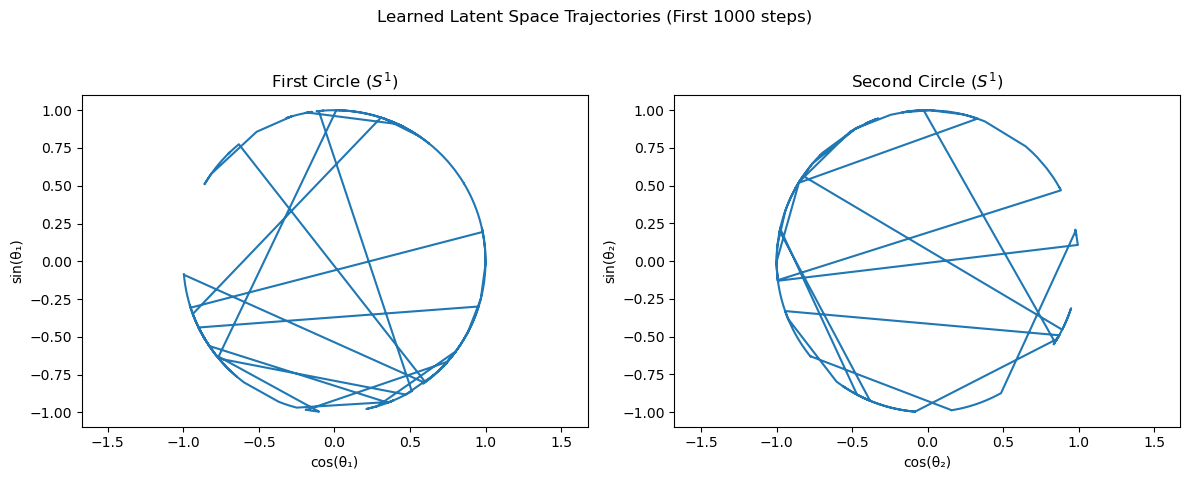

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os

# ===================================================================
# PART 1: LORENZ-96 데이터 생성
# ===================================================================

def generate_lorenz_data(filename='lorenz96_dataset.npy'):
    """
    Lorenz-96 데이터셋을 생성하고 파일로 저장합니다.
    파일이 이미 존재하면 생성 과정을 건너뜁니다.
    """
    if os.path.exists(filename):
        print(f"'{filename}' 파일이 이미 존재합니다. 데이터 생성을 건너뜁니다.")
        return

    print(f"'{filename}' 파일이 없어 새로 생성합니다...")
    
    # Lorenz-96 시스템 정의
    def lorenz96(t, x, N, F):
        dxdt = np.zeros(N)
        for i in range(N):
            x_prev2 = x[(i - 2 + N) % N]
            x_prev1 = x[(i - 1 + N) % N]
            x_next1 = x[(i + 1) % N]
            dxdt[i] = (x_next1 - x_prev2) * x_prev1 - x[i] + F
        return dxdt

    # 파라미터 설정
    N = 40
    F = 8.0
    dt = 0.01

    # 초기 조건
    np.random.seed(42)
    x0 = np.random.rand(N) * 0.01 + F 

    # 시스템 안정화 (Spin-up)
    spin_up_time = 10.0
    sol_spin_up = solve_ivp(lorenz96, [0, spin_up_time], x0, args=(N, F), dense_output=True)
    x0_stabilized = sol_spin_up.sol(spin_up_time)

    # 실제 데이터 생성
    T = 100.0
    t_eval = np.arange(0, T, dt)
    sol = solve_ivp(lorenz96, [0, T], x0_stabilized, args=(N, F), t_eval=t_eval)
    
    # 데이터 후처리 및 저장
    lorenz_data = sol.y.T
    np.save(filename, lorenz_data)
    print(f"'{filename}' 파일이 성공적으로 저장되었습니다. (형태: {lorenz_data.shape})")


# ===================================================================
# PART 2: TORUS 동역학 모델 학습
# ===================================================================

# --- 데이터셋 클래스 정의 ---
# --- 데이터셋 클래스 수정 ---
class TimeSeriesDataset(Dataset):
    def __init__(self, data, skip_steps=1): # 스텝 건너뛰기 인수 추가
        self.data = data
        self.skip_steps = skip_steps

    def __len__(self):
        return len(self.data) - self.skip_steps

    def __getitem__(self, idx):
        # idx번째 데이터와 (idx + skip_steps)번째 데이터를 반환
        return self.data[idx], self.data[idx + self.skip_steps]

# --- DataLoader 생성 시 skip_steps 설정 ---
# 예를 들어 10 스텝을 건너뛰도록 설정 (dt=0.01 * 10 = 0.1 시간 간격)

# --- 모델 아키텍처 정의 ---
class DynamicalTorusAutoencoder(nn.Module):
    def __init__(self, input_dim=40, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 128), 
                                     nn.GELU(), 
                                     nn.Linear(128, 64), 
                                     nn.GELU(), 
                                     nn.Linear(64, latent_dim))
        self.dynamics_map = nn.Sequential(nn.Linear(latent_dim, 64), 
                                          nn.GELU(), 
                                          nn.Linear(64, 64), 
                                          nn.GELU(), 
                                          nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), 
                                     nn.GELU(), 
                                     nn.Linear(64, 128), 
                                     nn.GELU(), 
                                     nn.Linear(128, input_dim))

    def to_torus(self, x_latent):
        s1, s2 = x_latent[:, :2], x_latent[:, 2:]
        s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
        s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
        return torch.cat([s1_norm, s2_norm], dim=1)

    def forward(self, x_n, x_n_plus_1):
        z_n_torus = self.to_torus(self.encoder(x_n))
        z_n_plus_1_torus_true = self.to_torus(self.encoder(x_n_plus_1))
        z_n_plus_1_torus_pred = self.to_torus(self.dynamics_map(z_n_torus))
        x_n_plus_1_reconstructed = self.decoder(z_n_plus_1_torus_pred)
        return x_n_plus_1_reconstructed, z_n_plus_1_torus_pred, z_n_plus_1_torus_true


if __name__ == '__main__':
    # --- 1. 데이터 준비 ---
    data_filename = 'lorenz96_dataset.npy'
    generate_lorenz_data(data_filename)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n학습에 사용할 장치: {device}")
    from sklearn.preprocessing import StandardScaler

    # 학습 데이터 로드 후
    
    lorenz_data = np.load(data_filename)
    scaler = StandardScaler()
    lorenz_data_scaled = scaler.fit_transform(lorenz_data)
    lorenz_tensor = torch.tensor(lorenz_data_scaled, dtype=torch.float32).to(device)

    #lorenz_tensor = torch.tensor(lorenz_data, dtype=torch.float32).to(device)
    
    #dataset = TimeSeriesDataset(lorenz_tensor)
    skip_steps = 10 
    dataset = TimeSeriesDataset(lorenz_tensor, skip_steps=skip_steps)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    

    # --- 2. 모델 및 학습 설정 ---
    model = DynamicalTorusAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    num_epochs = 100000

    # --- 3. 학습 루프 ---
    print("\n모델 학습을 시작합니다...")
    for epoch in range(num_epochs):
        total_loss = 0
        for x_n, x_n_plus_1 in dataloader:
            optimizer.zero_grad()
            x_pred, z_pred, z_true = model(x_n, x_n_plus_1)
            
            loss_reconstruction = loss_fn(x_pred, x_n_plus_1)
            loss_dynamics = loss_fn(z_pred, z_true)
            loss = loss_reconstruction + 0.1 * loss_dynamics # 손실 조합
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}")

    print("학습 완료!")

    # --- 4. 학습된 맵 저장 및 시각화 ---
    torch.save(model.dynamics_map.state_dict(), 'torus_dynamics_map.pth')
    print("\n학습된 동역학 맵이 'torus_dynamics_map.pth'에 저장되었습니다.")

    model.eval()
    with torch.no_grad():
        all_z_torus = model.to_torus(model.encoder(lorenz_tensor)).cpu().numpy()

    plt.figure(figsize=(12, 5))
    plt.suptitle("Learned Latent Space Trajectories (First 1000 steps)")
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(all_z_torus[:1000, 0], all_z_torus[:1000, 1])
    ax1.set_title("First Circle ($S^1$)")
    ax1.set_xlabel("cos(θ₁)"); ax1.set_ylabel("sin(θ₁)")
    ax1.axis('equal')

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(all_z_torus[:1000, 2], all_z_torus[:1000, 3])
    ax2.set_title("Second Circle ($S^1$)")
    ax2.set_xlabel("cos(θ₂)"); ax2.set_ylabel("sin(θ₂)")
    ax2.axis('equal')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

학습된 동역학 맵을 성공적으로 불러왔습니다.


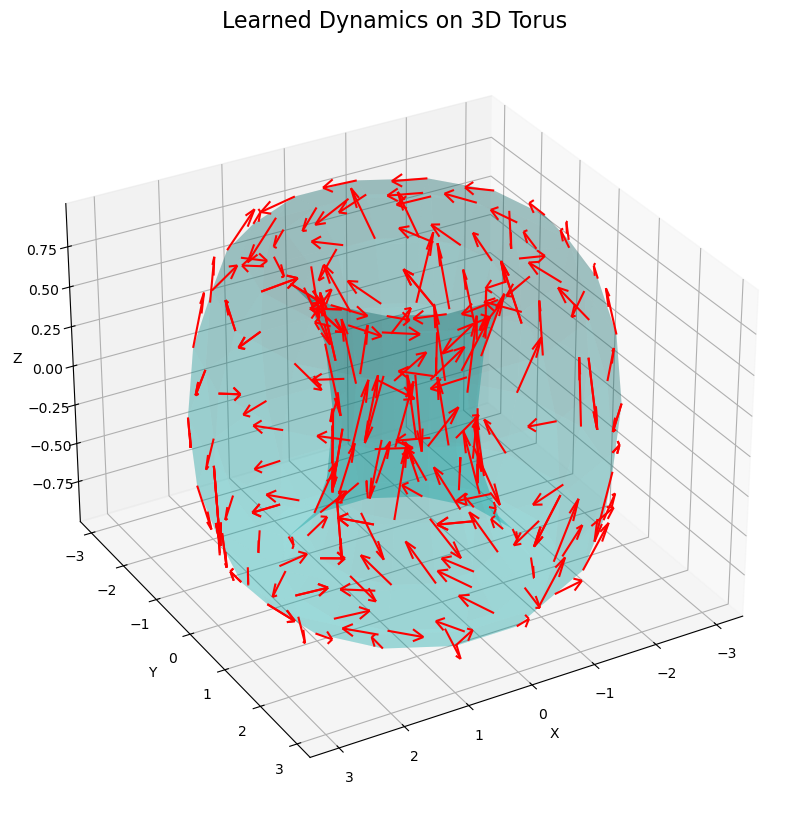

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 학습된 동역학 맵 모델 정의 및 로드 ---

# 모델 아키텍처는 학습 때와 동일해야 함
DynamicsMap = nn.Sequential(
    nn.Linear(4, 64),
    nn.GELU(),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Linear(64, 4)
)

# 저장된 state_dict 로드
try:
    DynamicsMap.load_state_dict(torch.load('torus_dynamics_map.pth'))
    DynamicsMap.eval()
    print("학습된 동역학 맵을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("오류: 'torus_dynamics_map.pth' 파일을 찾을 수 없습니다. 이전 단계의 학습을 먼저 실행해주세요.")
    exit()

# --- 2. 3D 토러스 파라미터 및 그리드 생성 ---

# 토러스를 3D로 표현하기 위한 함수
def torus_3d_embedding(theta1, theta2, R=2, r=1):
    x = (R + r * np.cos(theta1)) * np.cos(theta2)
    y = (R + r * np.cos(theta1)) * np.sin(theta2)
    z = r * np.sin(theta1)
    return x, y, z

# 토러스 표면에 그릴 점들의 그리드 생성
grid_size = 15
theta1 = np.linspace(0, 2 * np.pi, grid_size)
theta2 = np.linspace(0, 2 * np.pi, grid_size)
theta1_grid, theta2_grid = np.meshgrid(theta1, theta2)

# --- 3. 각 그리드 점에 대한 동역학 계산 ---

# 그리드 점들을 모델 입력 형식 (cos, sin, cos, sin)으로 변환
cos_t1 = np.cos(theta1_grid.ravel())
sin_t1 = np.sin(theta1_grid.ravel())
cos_t2 = np.cos(theta2_grid.ravel())
sin_t2 = np.sin(theta2_grid.ravel())

z_n = torch.tensor(np.stack([cos_t1, sin_t1, cos_t2, sin_t2], axis=-1), dtype=torch.float32)

# 동역학 맵을 통과시켜 다음 스텝 예측
with torch.no_grad():
    z_n_plus_1_latent = DynamicsMap(z_n)
    
    # 예측된 출력도 토러스 위로 정규화
    s1 = z_n_plus_1_latent[:, :2]
    s2 = z_n_plus_1_latent[:, 2:]
    s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
    s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
    z_n_plus_1 = torch.cat([s1_norm, s2_norm], dim=1).numpy()


# --- 4. 3D 시각화 ---

# 출발점과 도착점의 3D 좌표 계산
start_points_3d = np.array(torus_3d_embedding(theta1_grid.ravel(), theta2_grid.ravel()))

# 도착점 z_{n+1}의 각도 계산
theta1_next = np.arctan2(z_n_plus_1[:, 1], z_n_plus_1[:, 0])
theta2_next = np.arctan2(z_n_plus_1[:, 3], z_n_plus_1[:, 2])
end_points_3d = np.array(torus_3d_embedding(theta1_next, theta2_next))

# 화살표 벡터 계산 (도착점 - 출발점)
vectors = end_points_3d - start_points_3d

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 1. 토러스 표면 그리기 (반투명)
torus_surface_x, torus_surface_y, torus_surface_z = torus_3d_embedding(theta1_grid, theta2_grid)
ax.plot_surface(torus_surface_x, torus_surface_y, torus_surface_z, color='c', alpha=0.2, rstride=1, cstride=1)

# 2. 동역학 화살표 그리기 (Quiver plot)
ax.quiver(
    start_points_3d[0], start_points_3d[1], start_points_3d[2], # 화살표 시작점
    vectors[0], vectors[1], vectors[2],                         # 화살표 방향 벡터
    length=0.5, # 화살표 길이 조절
    normalize=True,
    color='r'
)

ax.set_title("Learned Dynamics on 3D Torus", fontsize=16)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
# 시야각 조절
ax.view_init(elev=30., azim=60)
plt.show()

In [14]:

# --- 0. 기본 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"분석에 사용할 장치: {device}")

# --- 1. 학습된 동역학 맵 모델 정의 및 로드 ---
DynamicsMap = nn.Sequential(
    nn.Linear(4, 64), nn.GELU(),
    nn.Linear(64, 64), nn.GELU(),
    nn.Linear(64, 4)
).to(device)

try:
    DynamicsMap.load_state_dict(torch.load('torus_dynamics_map.pth', map_location=device))
    DynamicsMap.eval()
    print("학습된 동역학 맵을 성공적으로 불러왔습니다.\n")
except FileNotFoundError:
    print("오류: 'torus_dynamics_map.pth' 파일을 찾을 수 없습니다. 이전 단계의 학습을 먼저 실행해주세요.")
    exit()

def to_torus(x_latent):
    s1, s2 = x_latent[:, :2], x_latent[:, 2:]
    s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
    s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
    return torch.cat([s1_norm, s2_norm], dim=1)
def to_torus(x_latent):
    s1, s2 = x_latent[:, :2], x_latent[:, 2:]
    s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
    s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
    return torch.cat([s1_norm, s2_norm], dim=1)

# --- 2. HCD (호몰로지 카오스 탐지기) 분석 ---
print("="*50)
print("HCD 분석을 시작합니다...")

# H1(T^2)의 기저 루프(basis loop) 샘플링
num_points = 2000
# 루프 1 (theta1 변화): meridian
t1_loop = np.linspace(0, 2 * np.pi, num_points)
loop1 = torch.tensor(np.stack([np.cos(t1_loop), np.sin(t1_loop), np.ones(num_points), np.zeros(num_points)], axis=-1), dtype=torch.float32).to(device)

# 루프 2 (theta2 변화): longitude
t2_loop = np.linspace(0, 2 * np.pi, num_points)
loop2 = torch.tensor(np.stack([np.ones(num_points), np.zeros(num_points), np.cos(t2_loop), np.sin(t2_loop)], axis=-1), dtype=torch.float32).to(device)

homology_matrix = np.zeros((2, 2), dtype=int)

with torch.no_grad():
    # f(loop1) 계산 및 와인딩 넘버 계산
    f_loop1 = to_torus(DynamicsMap(DynamicsMap(DynamicsMap(DynamicsMap(loop1))))).cpu().numpy()
    theta1_f1 = np.unwrap(np.arctan2(f_loop1[:, 1], f_loop1[:, 0]))
    theta2_f1 = np.unwrap(np.arctan2(f_loop1[:, 3], f_loop1[:, 2]))
    homology_matrix[0, 0] = np.round((theta1_f1[-1] - theta1_f1[0]) / (2 * np.pi))
    homology_matrix[1, 0] = np.round((theta2_f1[-1] - theta2_f1[0]) / (2 * np.pi))

    # f(loop2) 계산 및 와인딩 넘버 계산
    f_loop2 = to_torus(DynamicsMap(DynamicsMap(DynamicsMap(DynamicsMap(loop2))))).cpu().numpy()
    theta1_f2 = np.unwrap(np.arctan2(f_loop2[:, 1], f_loop2[:, 0]))
    theta2_f2 = np.unwrap(np.arctan2(f_loop2[:, 3], f_loop2[:, 2]))
    homology_matrix[0, 1] = np.round((theta1_f2[-1] - theta1_f2[0]) / (2 * np.pi))
    homology_matrix[1, 1] = np.round((theta2_f2[-1] - theta2_f2[0]) / (2 * np.pi))

print(f"\n계산된 유도 호몰로지 행렬 f_*:\n{homology_matrix}")

# 고유값 계산
eigenvalues, _ = np.linalg.eig(homology_matrix)
max_abs_eig = np.max(np.abs(eigenvalues))

print(f"\n행렬의 고유값: {eigenvalues}")
print(f"최대 고유값의 절댓값: {max_abs_eig:.4f}")

if max_abs_eig > 1:
    print("HCD 판별 결과: CHAOTIC (카오스적)")
else:
    print("HCD 판별 결과: STABLE (안정적)")
print("="*50)


# --- 3. 최대 리아푸노프 지수 (MLE) 분석 ---
print("\n" + "="*50)
print("최대 리아푸노프 지수(MLE) 분석을 시작합니다... (계산에 시간이 다소 소요될 수 있습니다)")

def get_jacobian(f, z):
    return torch.autograd.functional.jacobian(lambda x: to_torus(f(x)), z)

num_iterations = 2000
# 임의의 시작점과 탄젠트 벡터
z = torch.randn(1, 4).to(device)
z = z / torch.norm(z) * np.sqrt(2) # (1,1,1,1) 같은 점이 아니도록
v = torch.randn(1, 4).to(device)
v = v / torch.norm(v)

lyapunov_sum = 0
with torch.no_grad():
    for i in range(num_iterations):
        # 자코비안 계산
        J = get_jacobian(DynamicsMap, z)
        
        # 탄젠트 벡터 진화
        v_next = torch.matmul(J.squeeze(), v.squeeze())
        
        # 로컬 리아푸노프 값 계산 및 누적
        norm_v_next = torch.norm(v_next)
        lyapunov_sum += torch.log(norm_v_next).item()
        
        # 벡터 재정규화
        v = v_next / norm_v_next
        
        # 다음 상태로 이동
        z = to_torus(DynamicsMap(z))
        
# 평균을 내어 MLE 계산
mle = lyapunov_sum / num_iterations

print(f"\n계산된 최대 리아푸노프 지수: {mle:.4f}")
if mle > 0.01: # (수치적 오차를 고려해 0보다 약간 큰 값으로 기준 설정)
    print("MLE 판별 결과: CHAOTIC (카오스적)")
else:
    print("MLE 판별 결과: STABLE (안정적)")

print("="*50)

# --- 4. 최종 결론 ---
print("\n" + "="*50)
print("최종 분석 요약")
print(f"  - HCD 진단: {'CHAOTIC' if max_abs_eig > 1 else 'STABLE'} (max|λ| = {max_abs_eig:.4f})")
print(f"  - MLE 진단: {'CHAOTIC' if mle > 0.01 else 'STABLE'} (MLE = {mle:.4f})")
print("="*50)

분석에 사용할 장치: cuda
학습된 동역학 맵을 성공적으로 불러왔습니다.

HCD 분석을 시작합니다...

계산된 유도 호몰로지 행렬 f_*:
[[1 0]
 [1 0]]

행렬의 고유값: [0. 1.]
최대 고유값의 절댓값: 1.0000
HCD 판별 결과: STABLE (안정적)

최대 리아푸노프 지수(MLE) 분석을 시작합니다... (계산에 시간이 다소 소요될 수 있습니다)

계산된 최대 리아푸노프 지수: -0.3200
MLE 판별 결과: STABLE (안정적)

최종 분석 요약
  - HCD 진단: STABLE (max|λ| = 1.0000)
  - MLE 진단: STABLE (MLE = -0.3200)


학습된 동역학 맵을 성공적으로 불러왔습니다.


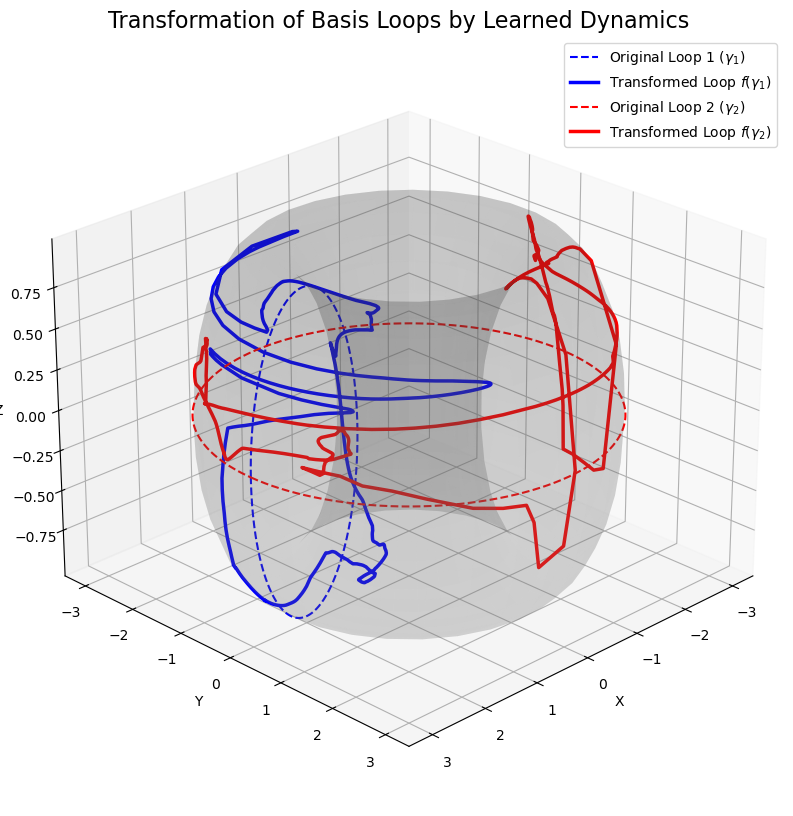

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 모델 및 헬퍼 함수 준비 ---

# 학습 때와 동일한 모델 아키텍처 정의
DynamicsMap = nn.Sequential(
    nn.Linear(4, 64), nn.GELU(),
    nn.Linear(64, 64), nn.GELU(),
    nn.Linear(64, 4)
)

# 저장된 모델 로드
try:
    DynamicsMap.load_state_dict(torch.load('torus_dynamics_map.pth'))
    DynamicsMap.eval()
    print("학습된 동역학 맵을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("오류: 'torus_dynamics_map.pth' 파일을 찾을 수 없습니다. 이전 단계의 학습을 먼저 실행해주세요.")
    exit()

# 토러스를 3D로 표현하기 위한 함수
def torus_3d_embedding(theta1, theta2, R=2, r=1):
    x = (R + r * np.cos(theta1)) * np.cos(theta2)
    y = (R + r * np.cos(theta1)) * np.sin(theta2)
    z = r * np.sin(theta1)
    return x, y, z

def to_torus_numpy(x_latent_np):
    s1, s2 = x_latent_np[:, :2], x_latent_np[:, 2:]
    s1_norm = s1 / (np.linalg.norm(s1, axis=1, keepdims=True) + 1e-8)
    s2_norm = s2 / (np.linalg.norm(s2, axis=1, keepdims=True) + 1e-8)
    return np.concatenate([s1_norm, s2_norm], axis=1)

# --- 2. 원본 루프 및 변환된 루프 계산 ---

num_points = 1000
# 원본 루프 1 (Meridian)
theta1_loop = np.linspace(0, 2 * np.pi, num_points)
loop1_tensor = torch.tensor(np.stack([np.cos(theta1_loop), np.sin(theta1_loop), np.ones(num_points), np.zeros(num_points)], axis=-1), dtype=torch.float32)

# 원본 루프 2 (Longitude)
theta2_loop = np.linspace(0, 2 * np.pi, num_points)
loop2_tensor = torch.tensor(np.stack([np.ones(num_points), np.zeros(num_points), np.cos(theta2_loop), np.sin(theta2_loop)], axis=-1), dtype=torch.float32)

# 동역학 맵으로 루프 변환
with torch.no_grad():
    f_loop1_latent = DynamicsMap(DynamicsMap(DynamicsMap(loop1_tensor))).numpy()
    f_loop2_latent = DynamicsMap(DynamicsMap(DynamicsMap(loop2_tensor))).numpy()
    
# 변환된 결과도 토러스 위로 정규화
f_loop1 = to_torus_numpy(f_loop1_latent)
f_loop2 = to_torus_numpy(f_loop2_latent)


# --- 3. 플로팅을 위한 3D 좌표 계산 ---

# 원본 루프들의 3D 좌표
original_loop1_3d = torus_3d_embedding(theta1_loop, 0)
original_loop2_3d = torus_3d_embedding(0, theta2_loop)

# 변환된 루프들의 3D 좌표
f_loop1_theta1 = np.arctan2(f_loop1[:, 1], f_loop1[:, 0])
f_loop1_theta2 = np.arctan2(f_loop1[:, 3], f_loop1[:, 2])
transformed_loop1_3d = torus_3d_embedding(f_loop1_theta1, f_loop1_theta2)

f_loop2_theta1 = np.arctan2(f_loop2[:, 1], f_loop2[:, 0])
f_loop2_theta2 = np.arctan2(f_loop2[:, 3], f_loop2[:, 2])
transformed_loop2_3d = torus_3d_embedding(f_loop2_theta1, f_loop2_theta2)

# --- 4. 3D 시각화 ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 토러스 표면 그리기 (배경)
grid_size = 30
theta1_surf = np.linspace(0, 2 * np.pi, grid_size)
theta2_surf = np.linspace(0, 2 * np.pi, grid_size)
theta1_grid, theta2_grid = np.meshgrid(theta1_surf, theta2_surf)
torus_x, torus_y, torus_z = torus_3d_embedding(theta1_grid, theta2_grid)
ax.plot_surface(torus_x, torus_y, torus_z, color='gray', alpha=0.15, rstride=1, cstride=1)

# 루프 그리기
# 루프 1 (Meridian)
ax.plot(*original_loop1_3d, color='blue', linestyle='--', label='Original Loop 1 ($\\gamma_1$)')
ax.plot(*transformed_loop1_3d, color='blue', linewidth=2.5, label='Transformed Loop $f(\\gamma_1)$')

# 루프 2 (Longitude)
ax.plot(*original_loop2_3d, color='red', linestyle='--', label='Original Loop 2 ($\\gamma_2$)')
ax.plot(*transformed_loop2_3d, color='red', linewidth=2.5, label='Transformed Loop $f(\\gamma_2)$')

ax.set_title("Transformation of Basis Loops by Learned Dynamics", fontsize=16)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend()
ax.view_init(elev=25., azim=45) # 시야각 조절
plt.show()

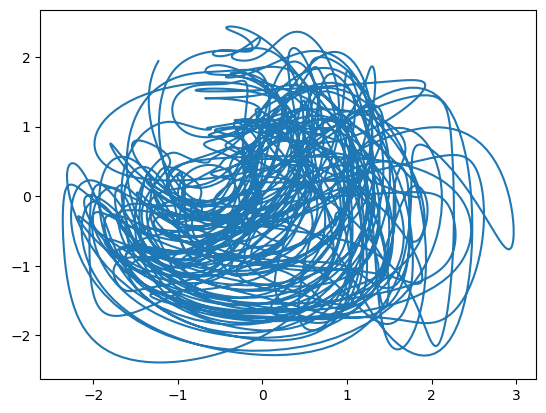

In [22]:
plt.plot(lorenz_data_scaled[:,0], lorenz_data_scaled[:,1])

20차원 Coupled Map Lattice 데이터를 생성합니다...
데이터 생성 완료.
'cml_dataset.npy' 파일이 성공적으로 저장되었습니다.


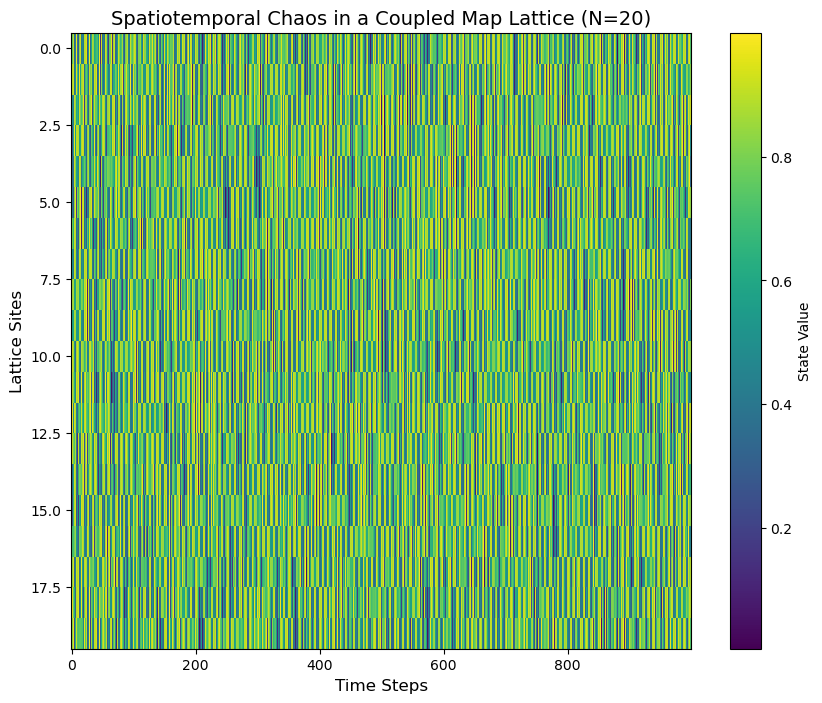

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cml_data(dim=20, num_steps=5000, mu=4.0, epsilon=0.2):
    """
    결합 사상 격자(Coupled Map Lattice) 데이터를 생성합니다.

    :param dim: 격자의 차원 (사이트의 개수)
    :param num_steps: 시뮬레이션할 시간 스텝 수
    :param mu: 로지스틱 맵의 파라미터 (mu=4.0일 때 카오스)
    :param epsilon: 이웃과의 결합 강도
    :return: (num_steps, dim) 형태의 데이터
    """
    print(f"{dim}차원 Coupled Map Lattice 데이터를 생성합니다...")
    
    # 로지스틱 맵 함수
    def logistic_map(x, mu):
        return mu * x * (1.0 - x)
    
    # 데이터 배열 초기화
    # (초기값의 과도기를 버리기 위해 200 스텝 추가 생성)
    transient_steps = 200
    total_steps = num_steps + transient_steps
    data = np.zeros((total_steps, dim))
    
    # 초기 조건 (0과 1 사이의 랜덤 값)
    np.random.seed(42)
    data[0, :] = np.random.rand(dim)
    
    # CML 이터레이션
    for t in range(total_steps - 1):
        x_t = data[t, :]
        
        # 각 사이트에 로지스틱 맵 적용
        f_x_t = logistic_map(x_t, mu)
        
        # 주기적 경계 조건을 위한 이웃 값 가져오기 (np.roll 사용)
        f_x_t_left = np.roll(f_x_t, 1)  # 오른쪽으로 한 칸 쉬프트 (i-1)
        f_x_t_right = np.roll(f_x_t, -1) # 왼쪽으로 한 칸 쉬프트 (i+1)
        
        # 다음 상태 계산
        data[t+1, :] = (1.0 - epsilon) * f_x_t + (epsilon / 2.0) * (f_x_t_left + f_x_t_right)

    # 초기 과도기 상태를 제외하고 최종 데이터 반환
    final_data = data[transient_steps:, :]
    print("데이터 생성 완료.")
    return final_data

# --- 데모: CML 데이터 생성 및 시공간 패턴 시각화 ---
if __name__ == '__main__':
    DIMENSION = 20
    cml_data = generate_cml_data(dim=DIMENSION, num_steps=1000)

    # 파일로 저장하여 다음 실험에 사용
    np.save('cml_dataset.npy', cml_data)
    print("'cml_dataset.npy' 파일이 성공적으로 저장되었습니다.")

    # 시공간 다이어그램 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(cml_data.T, cmap='viridis', aspect='auto', interpolation='nearest')
    plt.title(f'Spatiotemporal Chaos in a Coupled Map Lattice (N={DIMENSION})', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Lattice Sites', fontsize=12)
    plt.colorbar(label='State Value')
    plt.show()

In [ ]:

# ===================================================================
# PART 2: TORUS 동역학 모델 학습
# ===================================================================

# --- 데이터셋 클래스 정의 ---
# --- 데이터셋 클래스 수정 ---
class TimeSeriesDataset(Dataset):
    def __init__(self, data, skip_steps=1): # 스텝 건너뛰기 인수 추가
        self.data = data
        self.skip_steps = skip_steps

    def __len__(self):
        return len(self.data) - self.skip_steps

    def __getitem__(self, idx):
        # idx번째 데이터와 (idx + skip_steps)번째 데이터를 반환
        return self.data[idx], self.data[idx + self.skip_steps]

# --- DataLoader 생성 시 skip_steps 설정 ---

# --- 모델 아키텍처 정의 ---
class DynamicalTorusAutoencoder(nn.Module):
    def __init__(self, input_dim=40, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 128), 
                                     nn.GELU(), 
                                     nn.Linear(128, 64), 
                                     nn.GELU(), 
                                     nn.Linear(64, latent_dim))
        self.dynamics_map = nn.Sequential(nn.Linear(latent_dim, 64), 
                                          nn.GELU(), 
                                          nn.Linear(64, 64), 
                                          nn.GELU(), 
                                          nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), 
                                     nn.GELU(), 
                                     nn.Linear(64, 128), 
                                     nn.GELU(), 
                                     nn.Linear(128, input_dim))

    def to_torus(self, x_latent):
        s1, s2 = x_latent[:, :2], x_latent[:, 2:]
        s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
        s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
        return torch.cat([s1_norm, s2_norm], dim=1)

    def forward(self, x_n, x_n_plus_1):
        z_n_torus = self.to_torus(self.encoder(x_n))
        z_n_plus_1_torus_true = self.to_torus(self.encoder(x_n_plus_1))
        z_n_plus_1_torus_pred = self.to_torus(self.dynamics_map(z_n_torus))
        x_n_plus_1_reconstructed = self.decoder(z_n_plus_1_torus_pred)
        return x_n_plus_1_reconstructed, z_n_plus_1_torus_pred, z_n_plus_1_torus_true


if __name__ == '__main__':
    # --- 1. 데이터 준비 ---
    data_filename = 'cml_dataset.npy'
    generate_lorenz_data(data_filename)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n학습에 사용할 장치: {device}")
    from sklearn.preprocessing import StandardScaler

    # 학습 데이터 로드 후
    
    cml_data = np.load(data_filename)
    #scaler = StandardScaler()
    #lorenz_data_scaled = scaler.fit_transform(lorenz_data)
    cml_tensor = torch.tensor(cml_data, dtype=torch.float32).to(device)

    #lorenz_tensor = torch.tensor(lorenz_data, dtype=torch.float32).to(device)
    
    #dataset = TimeSeriesDataset(lorenz_tensor)
    skip_steps = 1
    dataset = TimeSeriesDataset(cml_tensor, skip_steps=skip_steps)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    

    # --- 2. 모델 및 학습 설정 ---
    model = DynamicalTorusAutoencoder(input_dim=20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    num_epochs = 50000

    # --- 3. 학습 루프 ---
    print("\n모델 학습을 시작합니다...")
    for epoch in range(num_epochs):
        total_loss = 0
        for x_n, x_n_plus_1 in dataloader:
            optimizer.zero_grad()
            x_pred, z_pred, z_true = model(x_n, x_n_plus_1)
            
            loss_reconstruction = loss_fn(x_pred, x_n_plus_1)
            loss_dynamics = loss_fn(z_pred, z_true)
            loss = loss_reconstruction + 0.1 * loss_dynamics # 손실 조합
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}")

    print("학습 완료!")


'cml_dataset.npy' 파일이 이미 존재합니다. 데이터 생성을 건너뜁니다.

학습에 사용할 장치: cuda

모델 학습을 시작합니다...
Epoch [1000/50000], Average Loss: 0.051561
Epoch [2000/50000], Average Loss: 0.051019
Epoch [3000/50000], Average Loss: 0.046358
Epoch [4000/50000], Average Loss: 0.045882
Epoch [5000/50000], Average Loss: 0.045636
Epoch [6000/50000], Average Loss: 0.045493
Epoch [7000/50000], Average Loss: 0.045381
Epoch [8000/50000], Average Loss: 0.045067
Epoch [9000/50000], Average Loss: 0.044752
Epoch [10000/50000], Average Loss: 0.044535
Epoch [11000/50000], Average Loss: 0.044735
Epoch [12000/50000], Average Loss: 0.044216
Epoch [13000/50000], Average Loss: 0.043830
Epoch [14000/50000], Average Loss: 0.043748
Epoch [15000/50000], Average Loss: 0.043650
Epoch [16000/50000], Average Loss: 0.043268
Epoch [17000/50000], Average Loss: 0.042859
Epoch [18000/50000], Average Loss: 0.042451
Epoch [19000/50000], Average Loss: 0.043888
Epoch [20000/50000], Average Loss: 0.042079
Epoch [21000/50000], Average Loss: 0.041879
Epo

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x40 and 20x128)


학습된 동역학 맵이 'torus_dynamics_map.pth'에 저장되었습니다.


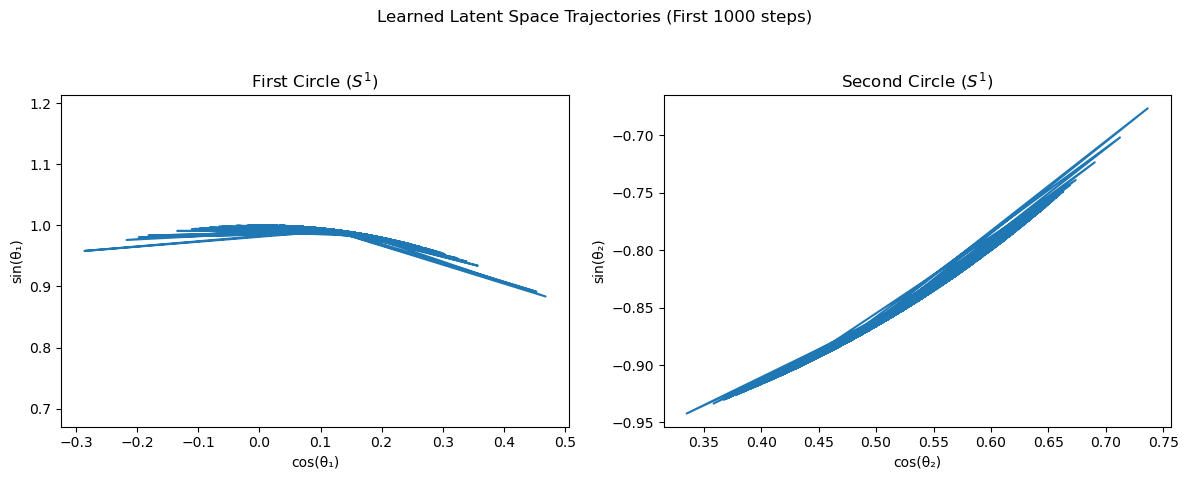

In [26]:

# --- 4. 학습된 맵 저장 및 시각화 ---
torch.save(model.dynamics_map.state_dict(), 'torus_dynamics_map.pth')
print("\n학습된 동역학 맵이 'torus_dynamics_map.pth'에 저장되었습니다.")

model.eval()
with torch.no_grad():
    all_z_torus = model.to_torus(model.encoder(cml_tensor)).cpu().numpy()

plt.figure(figsize=(12, 5))
plt.suptitle("Learned Latent Space Trajectories (First 1000 steps)")
ax1 = plt.subplot(1, 2, 1)
ax1.plot(all_z_torus[:1000, 0], all_z_torus[:1000, 1])
ax1.set_title("First Circle ($S^1$)")
ax1.set_xlabel("cos(θ₁)"); ax1.set_ylabel("sin(θ₁)")
ax1.axis('equal')

ax2 = plt.subplot(1, 2, 2)
ax2.plot(all_z_torus[:1000, 2], all_z_torus[:1000, 3])
ax2.set_title("Second Circle ($S^1$)")
ax2.set_xlabel("cos(θ₂)"); ax2.set_ylabel("sin(θ₂)")
ax2.axis('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

학습된 동역학 맵을 성공적으로 불러왔습니다.


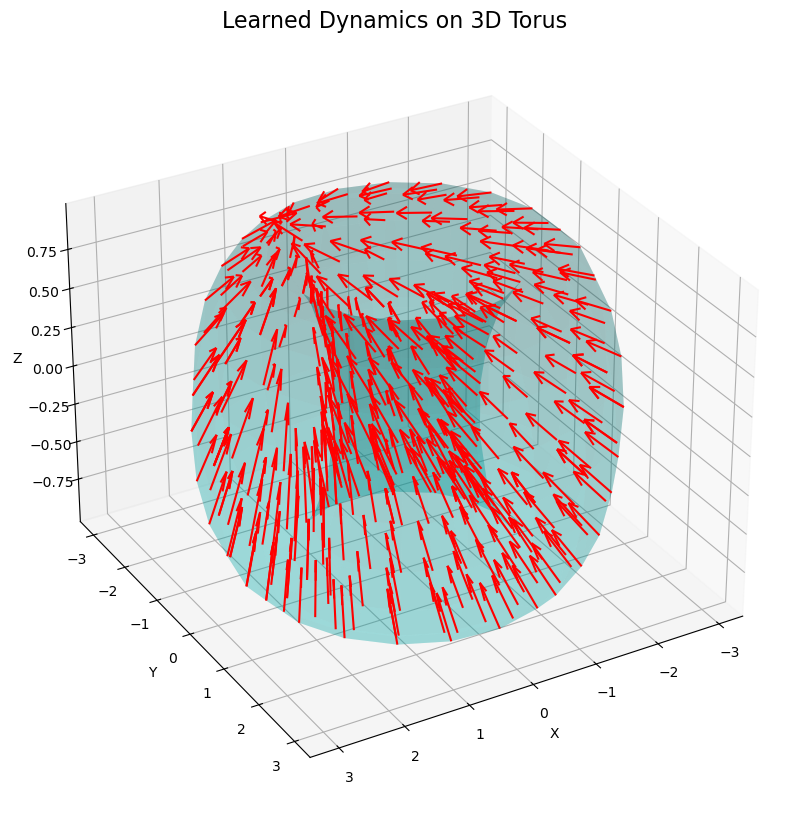

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 학습된 동역학 맵 모델 정의 및 로드 ---

# 모델 아키텍처는 학습 때와 동일해야 함
DynamicsMap = nn.Sequential(
    nn.Linear(4, 64),
    nn.GELU(),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Linear(64, 4)
)

# 저장된 state_dict 로드
try:
    DynamicsMap.load_state_dict(torch.load('torus_dynamics_map.pth'))
    DynamicsMap.eval()
    print("학습된 동역학 맵을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("오류: 'torus_dynamics_map.pth' 파일을 찾을 수 없습니다. 이전 단계의 학습을 먼저 실행해주세요.")
    exit()

# --- 2. 3D 토러스 파라미터 및 그리드 생성 ---

# 토러스를 3D로 표현하기 위한 함수
def torus_3d_embedding(theta1, theta2, R=2, r=1):
    x = (R + r * np.cos(theta1)) * np.cos(theta2)
    y = (R + r * np.cos(theta1)) * np.sin(theta2)
    z = r * np.sin(theta1)
    return x, y, z

# 토러스 표면에 그릴 점들의 그리드 생성
grid_size = 20
theta1 = np.linspace(0, 2 * np.pi, grid_size)
theta2 = np.linspace(0, 2 * np.pi, grid_size)
theta1_grid, theta2_grid = np.meshgrid(theta1, theta2)

# --- 3. 각 그리드 점에 대한 동역학 계산 ---

# 그리드 점들을 모델 입력 형식 (cos, sin, cos, sin)으로 변환
cos_t1 = np.cos(theta1_grid.ravel())
sin_t1 = np.sin(theta1_grid.ravel())
cos_t2 = np.cos(theta2_grid.ravel())
sin_t2 = np.sin(theta2_grid.ravel())

z_n = torch.tensor(np.stack([cos_t1, sin_t1, cos_t2, sin_t2], axis=-1), dtype=torch.float32)

# 동역학 맵을 통과시켜 다음 스텝 예측
with torch.no_grad():
    z_n_plus_1_latent = DynamicsMap(z_n)
    
    # 예측된 출력도 토러스 위로 정규화
    s1 = z_n_plus_1_latent[:, :2]
    s2 = z_n_plus_1_latent[:, 2:]
    s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
    s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
    z_n_plus_1 = torch.cat([s1_norm, s2_norm], dim=1).numpy()


# --- 4. 3D 시각화 ---

# 출발점과 도착점의 3D 좌표 계산
start_points_3d = np.array(torus_3d_embedding(theta1_grid.ravel(), theta2_grid.ravel()))

# 도착점 z_{n+1}의 각도 계산
theta1_next = np.arctan2(z_n_plus_1[:, 1], z_n_plus_1[:, 0])
theta2_next = np.arctan2(z_n_plus_1[:, 3], z_n_plus_1[:, 2])
end_points_3d = np.array(torus_3d_embedding(theta1_next, theta2_next))

# 화살표 벡터 계산 (도착점 - 출발점)
vectors = end_points_3d - start_points_3d

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 1. 토러스 표면 그리기 (반투명)
torus_surface_x, torus_surface_y, torus_surface_z = torus_3d_embedding(theta1_grid, theta2_grid)
ax.plot_surface(torus_surface_x, torus_surface_y, torus_surface_z, color='c', alpha=0.2, rstride=1, cstride=1)

# 2. 동역학 화살표 그리기 (Quiver plot)
ax.quiver(
    start_points_3d[0], start_points_3d[1], start_points_3d[2], # 화살표 시작점
    vectors[0], vectors[1], vectors[2],                         # 화살표 방향 벡터
    length=0.5, # 화살표 길이 조절
    normalize=True,
    color='r'
)

ax.set_title("Learned Dynamics on 3D Torus", fontsize=16)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
# 시야각 조절
ax.view_init(elev=30., azim=60)
plt.show()

In [29]:

# --- 0. 기본 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"분석에 사용할 장치: {device}")

# --- 1. 학습된 동역학 맵 모델 정의 및 로드 ---
DynamicsMap = nn.Sequential(
    nn.Linear(4, 64), nn.GELU(),
    nn.Linear(64, 64), nn.GELU(),
    nn.Linear(64, 4)
).to(device)

try:
    DynamicsMap.load_state_dict(torch.load('torus_dynamics_map.pth', map_location=device))
    DynamicsMap.eval()
    print("학습된 동역학 맵을 성공적으로 불러왔습니다.\n")
except FileNotFoundError:
    print("오류: 'torus_dynamics_map.pth' 파일을 찾을 수 없습니다. 이전 단계의 학습을 먼저 실행해주세요.")
    exit()

def to_torus(x_latent):
    s1, s2 = x_latent[:, :2], x_latent[:, 2:]
    s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
    s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
    return torch.cat([s1_norm, s2_norm], dim=1)
def to_torus(x_latent):
    s1, s2 = x_latent[:, :2], x_latent[:, 2:]
    s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8)
    s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
    return torch.cat([s1_norm, s2_norm], dim=1)

# --- 2. HCD (호몰로지 카오스 탐지기) 분석 ---
print("="*50)
print("HCD 분석을 시작합니다...")

# H1(T^2)의 기저 루프(basis loop) 샘플링
num_points = 2000
# 루프 1 (theta1 변화): meridian
t1_loop = np.linspace(0, 2 * np.pi, num_points)
loop1 = torch.tensor(np.stack([np.cos(t1_loop), np.sin(t1_loop), np.ones(num_points), np.zeros(num_points)], axis=-1), dtype=torch.float32).to(device)

# 루프 2 (theta2 변화): longitude
t2_loop = np.linspace(0, 2 * np.pi, num_points)
loop2 = torch.tensor(np.stack([np.ones(num_points), np.zeros(num_points), np.cos(t2_loop), np.sin(t2_loop)], axis=-1), dtype=torch.float32).to(device)

homology_matrix = np.zeros((2, 2), dtype=int)

with torch.no_grad():
    # f(loop1) 계산 및 와인딩 넘버 계산
    f_loop1 = to_torus(DynamicsMap(loop1)).cpu().numpy()
    theta1_f1 = np.unwrap(np.arctan2(f_loop1[:, 1], f_loop1[:, 0]))
    theta2_f1 = np.unwrap(np.arctan2(f_loop1[:, 3], f_loop1[:, 2]))
    homology_matrix[0, 0] = np.round((theta1_f1[-1] - theta1_f1[0]) / (2 * np.pi))
    homology_matrix[1, 0] = np.round((theta2_f1[-1] - theta2_f1[0]) / (2 * np.pi))

    # f(loop2) 계산 및 와인딩 넘버 계산
    f_loop2 = to_torus(DynamicsMap(loop2)).cpu().numpy()
    theta1_f2 = np.unwrap(np.arctan2(f_loop2[:, 1], f_loop2[:, 0]))
    theta2_f2 = np.unwrap(np.arctan2(f_loop2[:, 3], f_loop2[:, 2]))
    homology_matrix[0, 1] = np.round((theta1_f2[-1] - theta1_f2[0]) / (2 * np.pi))
    homology_matrix[1, 1] = np.round((theta2_f2[-1] - theta2_f2[0]) / (2 * np.pi))

print(f"\n계산된 유도 호몰로지 행렬 f_*:\n{homology_matrix}")

# 고유값 계산
eigenvalues, _ = np.linalg.eig(homology_matrix)
max_abs_eig = np.max(np.abs(eigenvalues))

print(f"\n행렬의 고유값: {eigenvalues}")
print(f"최대 고유값의 절댓값: {max_abs_eig:.4f}")

if max_abs_eig > 1:
    print("HCD 판별 결과: CHAOTIC (카오스적)")
else:
    print("HCD 판별 결과: STABLE (안정적)")
print("="*50)


# --- 3. 최대 리아푸노프 지수 (MLE) 분석 ---
print("\n" + "="*50)
print("최대 리아푸노프 지수(MLE) 분석을 시작합니다... (계산에 시간이 다소 소요될 수 있습니다)")

def get_jacobian(f, z):
    return torch.autograd.functional.jacobian(lambda x: to_torus(f(x)), z)

num_iterations = 2000
# 임의의 시작점과 탄젠트 벡터
z = torch.randn(1, 4).to(device)
z = z / torch.norm(z) * np.sqrt(2) # (1,1,1,1) 같은 점이 아니도록
v = torch.randn(1, 4).to(device)
v = v / torch.norm(v)

lyapunov_sum = 0
with torch.no_grad():
    for i in range(num_iterations):
        # 자코비안 계산
        J = get_jacobian(DynamicsMap, z)
        
        # 탄젠트 벡터 진화
        v_next = torch.matmul(J.squeeze(), v.squeeze())
        
        # 로컬 리아푸노프 값 계산 및 누적
        norm_v_next = torch.norm(v_next)
        lyapunov_sum += torch.log(norm_v_next).item()
        
        # 벡터 재정규화
        v = v_next / norm_v_next
        
        # 다음 상태로 이동
        z = to_torus(DynamicsMap(z))
        
# 평균을 내어 MLE 계산
mle = lyapunov_sum / num_iterations

print(f"\n계산된 최대 리아푸노프 지수: {mle:.4f}")
if mle > 0.01: # (수치적 오차를 고려해 0보다 약간 큰 값으로 기준 설정)
    print("MLE 판별 결과: CHAOTIC (카오스적)")
else:
    print("MLE 판별 결과: STABLE (안정적)")

print("="*50)

# --- 4. 최종 결론 ---
print("\n" + "="*50)
print("최종 분석 요약")
print(f"  - HCD 진단: {'CHAOTIC' if max_abs_eig > 1 else 'STABLE'} (max|λ| = {max_abs_eig:.4f})")
print(f"  - MLE 진단: {'CHAOTIC' if mle > 0.01 else 'STABLE'} (MLE = {mle:.4f})")
print("="*50)

분석에 사용할 장치: cuda
학습된 동역학 맵을 성공적으로 불러왔습니다.

HCD 분석을 시작합니다...

계산된 유도 호몰로지 행렬 f_*:
[[0 0]
 [0 0]]

행렬의 고유값: [0. 0.]
최대 고유값의 절댓값: 0.0000
HCD 판별 결과: STABLE (안정적)

최대 리아푸노프 지수(MLE) 분석을 시작합니다... (계산에 시간이 다소 소요될 수 있습니다)

계산된 최대 리아푸노프 지수: -0.7470
MLE 판별 결과: STABLE (안정적)

최종 분석 요약
  - HCD 진단: STABLE (max|λ| = 0.0000)
  - MLE 진단: STABLE (MLE = -0.7470)


1. 카오스에 대한 수학적 증명
행렬 A의 행렬식 (Determinant): -1
-> 행렬식 조건 충족 (det = ±1)

행렬 A의 고유값:
[ 3.21431974  0.46081113 -0.67513087]

고유값의 절댓값:
[3.21431974 0.46081113 0.67513087]

-> 최대 고유값 크기(3.2143)가 1보다 크므로 카오스 조건 충족.

시스템의 리아푸노프 지수 (log|λ|):
[ 1.16761575 -0.77476702 -0.39284872]
-> 양수 리아푸노프 지수가 존재하므로, 시스템은 카오스적입니다.

2. 카오스에 대한 시각적 증명
3D 공간에 궤적을 그려 이상한 끌개(Strange Attractor)를 확인합니다...


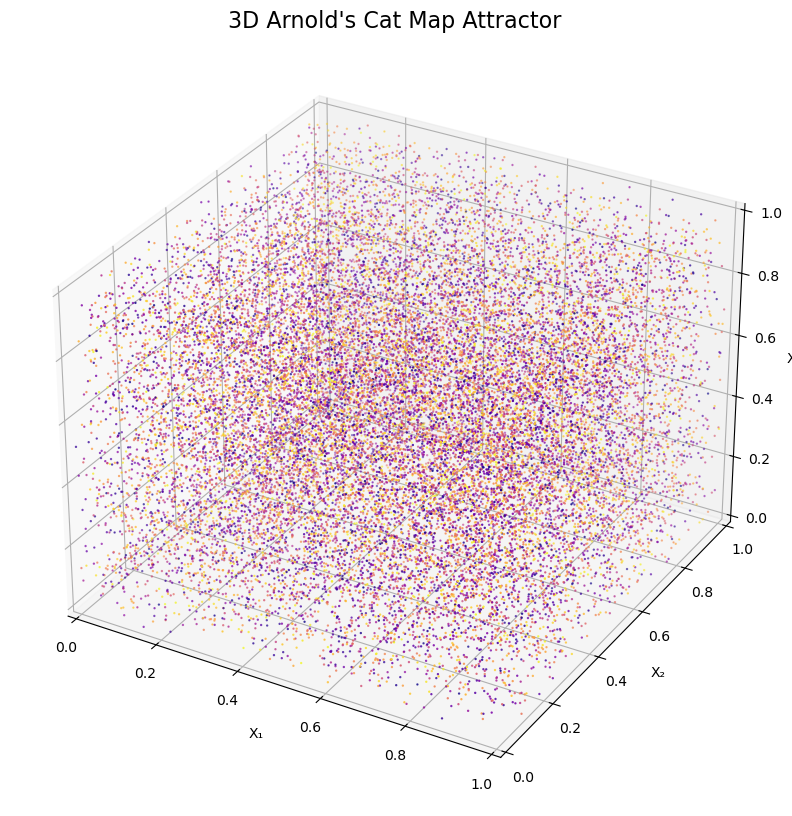

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def high_dim_cat_map(x, A):
    """
    고차원 Arnold's Cat Map 함수.

    :param x: n차원 상태 벡터 (numpy array)
    :param A: n x n 정수 행렬
    :return: 다음 상태 벡터
    """
    return np.dot(A, x) % 1.0

# --- 데모: 3차원 Cat Map 생성, 증명 및 시각화 ---
if __name__ == '__main__':
    # 1. 시스템 정의: 3x3 카오스 행렬 A
    # 조건: 정수 행렬, det(A) = ±1, |λ|≠1 인 고유값이 존재
    A = np.array([[2, 1, 1],
                  [1, 1, 1],
                  [1, 1, 0]], dtype=int)

    print("="*50)
    print("1. 카오스에 대한 수학적 증명")
    print("="*50)
    
    # 조건 1: 행렬식 확인
    det_A = np.linalg.det(A)
    print(f"행렬 A의 행렬식 (Determinant): {det_A:.0f}")
    if np.round(np.abs(det_A)) != 1:
        print("경고: 행렬식의 절댓값이 1이 아니므로, 유효한 Cat Map이 아닙니다.")
    else:
        print("-> 행렬식 조건 충족 (det = ±1)")

    # 조건 2: 고유값 확인
    eigenvalues, _ = np.linalg.eig(A)
    eigenvalue_magnitudes = np.abs(eigenvalues)
    lyapunov_exponents = np.log(eigenvalue_magnitudes)

    print(f"\n행렬 A의 고유값:\n{eigenvalues}")
    print(f"\n고유값의 절댓값:\n{eigenvalue_magnitudes}")
    
    max_eig_mag = np.max(eigenvalue_magnitudes)
    if max_eig_mag > 1:
        print(f"\n-> 최대 고유값 크기({max_eig_mag:.4f})가 1보다 크므로 카오스 조건 충족.")
    else:
        print("\n-> 최대 고유값 크기가 1보다 크지 않으므로 카오스가 아닙니다.")
        
    print("\n시스템의 리아푸노프 지수 (log|λ|):")
    print(lyapunov_exponents)
    if np.any(lyapunov_exponents > 0):
        print("-> 양수 리아푸노프 지수가 존재하므로, 시스템은 카오스적입니다.")
    
    print("\n" + "="*50)
    print("2. 카오스에 대한 시각적 증명")
    print("="*50)
    print("3D 공간에 궤적을 그려 이상한 끌개(Strange Attractor)를 확인합니다...")

    # 2. 궤적 생성
    num_iterations = 25000
    trajectory = np.zeros((num_iterations, 3))
    np.random.seed(0)
    trajectory[0] = np.random.rand(3)

    for i in range(num_iterations - 1):
        trajectory[i+1] = high_dim_cat_map(trajectory[i], A)

    # 3. 3D 시각화
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 궤적을 색상과 함께 플로팅
    ax.scatter(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
               c=np.linspace(0, 1, num_iterations), cmap='plasma', s=0.5)
    
    ax.set_title("3D Arnold's Cat Map Attractor", fontsize=16)
    ax.set_xlabel("X₁"); ax.set_ylabel("X₂"); ax.set_zlabel("X₃")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
    plt.show()

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import time

# --- 0. 기본 설정 및 모델/데이터셋 클래스 정의 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

class TimeSeriesDataset(Dataset):
    def __init__(self, data, skip_steps=1):
        self.data = data
        self.skip_steps = skip_steps
    def __len__(self):
        return len(self.data) - self.skip_steps
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx + self.skip_steps]

class DynamicalTorusAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 64), nn.GELU(), nn.Linear(64, 32), nn.GELU(), nn.Linear(32, latent_dim))
        self.dynamics_map = nn.Linear(latent_dim, latent_dim, bias=False)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.GELU(), nn.Linear(32, 64), nn.GELU(), nn.Linear(64, input_dim))
    def to_torus(self, x_latent):
        s1, s2 = x_latent[:, :2], x_latent[:, 2:]
        s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8); s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
        return torch.cat([s1_norm, s2_norm], dim=1)
    def forward(self, x_n, x_n_plus_k):
        z_n_torus = self.to_torus(self.encoder(x_n))
        z_n_plus_k_torus_true = self.to_torus(self.encoder(x_n_plus_k))
        z_n_plus_k_torus_pred = self.to_torus(self.dynamics_map(z_n_torus))
        x_n_plus_k_reconstructed = self.decoder(z_n_plus_k_torus_pred)
        return x_n_plus_k_reconstructed, z_n_plus_k_torus_pred, z_n_plus_k_torus_true

# --- 1. 메인 실행 부분 ---
if __name__ == '__main__':
    # === 섹션 A: 3D Cat Map 데이터 생성 ===
    print("--- 3D Cat Map 데이터 생성 시작 ---")
    A = np.array([[2, 1, 1], [1, 1, 1], [1, 1, 0]], dtype=int)
    num_steps = 15000
    cat_map_data = np.zeros((num_steps, 3))
    np.random.seed(42)
    cat_map_data[0] = np.random.rand(3)
    for i in range(num_steps - 1):
        cat_map_data[i+1] = np.dot(A, cat_map_data[i]) % 1.0
    
    cat_map_tensor = torch.tensor(cat_map_data, dtype=torch.float32).to(device)
    dataset = TimeSeriesDataset(cat_map_tensor, skip_steps=1)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
    print("--- 데이터 생성 완료 ---\n")

    # === 섹션 B: 모델 학습 ===
    # === 섹션 B: 모델 학습 (수정된 버전) ===
    print("--- 모델 학습 시작 (개선된 손실 함수 적용) ---")
    # Dynamics Map의 용량이 너무 클 수 있으므로, 약간 줄여서 안정성 확보
    model = DynamicalTorusAutoencoder(input_dim=3).to(device)
    # model.dynamics_map = nn.Sequential(nn.Linear(4, 64), nn.GELU(), nn.Linear(64, 64), nn.GELU(), nn.Linear(64, 4)).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4) # 학습률을 약간 낮춰 안정적인 학습 유도
    loss_fn = nn.MSELoss()
    num_epochs = 10000 # 개선된 손실 함수 덕분에 더 적은 epoch으로도 수렴 가능

    # 손실 가중치
    lambda_identity = 1.0
    lambda_prediction = 1.0
    lambda_latent = 1.0

    start_time = time.time()
    for epoch in range(num_epochs):
        for x_n, x_n_plus_1 in dataloader:
            optimizer.zero_grad()

            # 모델 순전파
            z_n_torus = model.to_torus(model.encoder(x_n))
            z_n_plus_1_torus_true = model.to_torus(model.encoder(x_n_plus_1))
            z_n_plus_1_torus_pred = model.to_torus(model.dynamics_map(z_n_torus))

            # --- 세 가지 복원 결과 계산 ---
            # 1. 자기 복원
            x_n_reconstructed = model.decoder(z_n_torus)
            # 2. 예측 복원
            x_n_plus_1_reconstructed = model.decoder(z_n_plus_1_torus_pred)

            # --- 세 가지 손실 계산 ---
            loss_identity_recon = loss_fn(x_n_reconstructed, x_n)
            loss_prediction_recon = loss_fn(x_n_plus_1_reconstructed, x_n_plus_1)
            loss_latent_dynamics = loss_fn(z_n_plus_1_torus_pred, z_n_plus_1_torus_true)

            # 최종 손실 = 세 가지 손실의 가중합
            loss = (lambda_identity * loss_identity_recon +
                    lambda_prediction * loss_prediction_recon +
                    lambda_latent * loss_latent_dynamics)

            loss.backward()
            optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss [{loss.item():.6f}]")

    end_time = time.time()
    print(f"--- 학습 완료 (소요 시간: {end_time - start_time:.2f}초) ---\n")

    # === 섹션 C: 학습된 모델 분석 ===
    dynamics_map = model.dynamics_map
    
    # HCD 분석
    print("="*50)
    print("HCD 분석 결과")
    print("="*50)
    homology_matrix = np.zeros((2, 2), dtype=int)
    num_points = 2000
    t1_loop = np.linspace(0, 2*np.pi, num_points); t2_loop = np.linspace(0, 2*np.pi, num_points)
    loop1 = torch.tensor(np.stack([np.cos(t1_loop), np.sin(t1_loop), np.ones(num_points), np.zeros(num_points)], axis=-1), dtype=torch.float32).to(device)
    loop2 = torch.tensor(np.stack([np.ones(num_points), np.zeros(num_points), np.cos(t2_loop), np.sin(t2_loop)], axis=-1), dtype=torch.float32).to(device)
    with torch.no_grad():
        f_loop1 = model.to_torus(dynamics_map(loop1)).cpu().numpy()
        theta1_f1 = np.unwrap(np.arctan2(f_loop1[:, 1], f_loop1[:, 0])); theta2_f1 = np.unwrap(np.arctan2(f_loop1[:, 3], f_loop1[:, 2]))
        homology_matrix[0, 0] = np.round((theta1_f1[-1] - theta1_f1[0]) / (2 * np.pi)); homology_matrix[1, 0] = np.round((theta2_f1[-1] - theta2_f1[0]) / (2 * np.pi))
        f_loop2 = model.to_torus(dynamics_map(loop2)).cpu().numpy()
        theta1_f2 = np.unwrap(np.arctan2(f_loop2[:, 1], f_loop2[:, 0])); theta2_f2 = np.unwrap(np.arctan2(f_loop2[:, 3], f_loop2[:, 2]))
        homology_matrix[0, 1] = np.round((theta1_f2[-1] - theta1_f2[0]) / (2 * np.pi)); homology_matrix[1, 1] = np.round((theta2_f2[-1] - theta2_f2[0]) / (2 * np.pi))
    eigenvalues, _ = np.linalg.eig(homology_matrix)
    max_abs_eig = np.max(np.abs(eigenvalues))
    print(f"  - 유도 호몰로지 행렬 f_*:\n{homology_matrix}")
    print(f"  - 최대 고유값 |λ|: {max_abs_eig:.4f}")
    print(f"  - HCD 진단: {'CHAOTIC' if max_abs_eig > 1 else 'STABLE'}")

    # MLE 분석
    print("\n" + "="*50)
    print("최대 리아푸노프 지수(MLE) 분석 결과")
    print("="*50)
    def get_jacobian(f, z): return torch.autograd.functional.jacobian(lambda x: model.to_torus(f(x)), z)
    num_iterations = 2000
    z = torch.randn(1, 4).to(device); z = z / torch.norm(z) * np.sqrt(2)
    v = torch.randn(1, 4).to(device); v = v / torch.norm(v)
    lyapunov_sum = 0
    with torch.no_grad():
        for i in range(num_iterations):
            J = get_jacobian(dynamics_map, z)
            v_next = torch.matmul(J.squeeze(), v.squeeze())
            norm_v_next = torch.norm(v_next)
            if norm_v_next > 1e-8: # 수치적 안정성을 위해
                lyapunov_sum += torch.log(norm_v_next).item()
                v = v_next / norm_v_next
            z = model.to_torus(dynamics_map(z))
    mle = lyapunov_sum / num_iterations
    print(f"  - 계산된 MLE: {mle:.4f}")
    print(f"  - MLE 진단: {'CHAOTIC' if mle > 0.01 else 'STABLE'}")
    print("="*50)

사용 장치: cuda
--- 3D Cat Map 데이터 생성 시작 ---
--- 데이터 생성 완료 ---

--- 모델 학습 시작 (개선된 손실 함수 적용) ---
Epoch [500/10000], Loss [0.116972]
Epoch [1000/10000], Loss [0.114889]
Epoch [1500/10000], Loss [0.116742]
Epoch [2000/10000], Loss [0.106965]
Epoch [2500/10000], Loss [0.111645]
Epoch [3000/10000], Loss [0.111382]
Epoch [3500/10000], Loss [0.110403]
Epoch [4000/10000], Loss [0.114870]
Epoch [4500/10000], Loss [0.107666]
Epoch [5000/10000], Loss [0.111037]
Epoch [5500/10000], Loss [0.101935]
Epoch [6000/10000], Loss [0.116433]
Epoch [6500/10000], Loss [0.105531]
Epoch [7000/10000], Loss [0.113605]
Epoch [7500/10000], Loss [0.110916]
Epoch [8000/10000], Loss [0.114061]
Epoch [8500/10000], Loss [0.106515]
Epoch [9000/10000], Loss [0.111248]
Epoch [9500/10000], Loss [0.112208]
Epoch [10000/10000], Loss [0.111157]
--- 학습 완료 (소요 시간: 4666.30초) ---

HCD 분석 결과
  - 유도 호몰로지 행렬 f_*:
[[0 0]
 [0 0]]
  - 최대 고유값 |λ|: 0.0000
  - HCD 진단: STABLE

최대 리아푸노프 지수(MLE) 분석 결과
  - 계산된 MLE: -0.2521
  - MLE 진단: STABLE


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import time

# --- 0. 기본 설정 및 모델/데이터셋 클래스 정의 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# TimeSeriesDataset은 2단계에서 사용
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data) - 1
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+1]

class DynamicalTorusAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 64), nn.GELU(), nn.Linear(64, 32), nn.GELU(), nn.Linear(32, latent_dim))
        self.dynamics_map = nn.Linear(latent_dim, latent_dim, bias=False)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.GELU(), nn.Linear(32, 64), nn.GELU(), nn.Linear(64, input_dim))
    def to_torus(self, x_latent):
        s1, s2 = x_latent[:, :2], x_latent[:, 2:]
        s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8); s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
        return torch.cat([s1_norm, s2_norm], dim=1)

# --- 1. 메인 실행 부분 ---
if __name__ == '__main__':
    # === 섹션 A: 3D Cat Map 데이터 생성 ===
    A = np.array([[2, 1, 1], [1, 1, 1], [1, 1, 0]], dtype=int)
    num_steps = 15000; dim = 3
    data = np.zeros((num_steps, dim)); np.random.seed(42); data[0] = np.random.rand(dim)
    for i in range(num_steps - 1): data[i+1] = np.dot(A, data[i]) % 1.0
    tensor_data = torch.tensor(data, dtype=torch.float32).to(device)
    
    # === 섹션 B: 모델 초기화 ===
    model = DynamicalTorusAutoencoder(input_dim=dim).to(device)
    loss_fn = nn.MSELoss()

    ### --- 1단계: 오토인코더 예비 학습 (Autoencoder Pre-training) --- ###
    print("="*50)
    print("1단계: 오토인코더 예비 학습 시작")
    print("="*50)
    
    # 예비 학습용 데이터로더 (개별 데이터 포인트만 사용)
    pretrain_dataset = TensorDataset(tensor_data)
    pretrain_dataloader = DataLoader(pretrain_dataset, batch_size=256, shuffle=True)
    pretrain_optimizer = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=1e-3)
    num_pretrain_epochs = 50

    for epoch in range(num_pretrain_epochs):
        for batch in pretrain_dataloader:
            x_n = batch[0]
            pretrain_optimizer.zero_grad()
            
            # 자기 복원 과정
            z_n_torus = model.to_torus(model.encoder(x_n))
            x_n_reconstructed = model.decoder(z_n_torus)
            
            # 자기 복원 손실만으로 학습
            loss = loss_fn(x_n_reconstructed, x_n)
            loss.backward()
            pretrain_optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Pre-train Epoch [{epoch+1}/{num_pretrain_epochs}], Reconstruction Loss: {loss.item():.6f}")
    
    print("--- 1단계 학습 완료 ---\n")

    ### --- 2단계: 전체 모델 미세 조정 (Dynamics Fine-tuning) --- ###
    print("="*50)
    print("2단계: 전체 모델 미세 조정 시작")
    print("="*50)

    # 미세 조정용 데이터로더 (데이터 쌍 사용)
    finetune_dataset = TimeSeriesDataset(tensor_data)
    finetune_dataloader = DataLoader(finetune_dataset, batch_size=256, shuffle=True)
    finetune_optimizer = optim.Adam(model.parameters(), lr=1e-4) # 더 낮은 학습률 사용
    num_finetune_epochs = 150

    # 손실 가중치
    lambda_identity = 1.0; lambda_prediction = 1.0; lambda_latent = 0.2

    for epoch in range(num_finetune_epochs):
        for x_n, x_n_plus_1 in finetune_dataloader:
            finetune_optimizer.zero_grad()
            
            # 전체 모델 순전파
            z_n_torus = model.to_torus(model.encoder(x_n))
            z_n_plus_1_torus_true = model.to_torus(model.encoder(x_n_plus_1))
            z_n_plus_1_torus_pred = model.to_torus(model.dynamics_map(z_n_torus))
            x_n_reconstructed = model.decoder(z_n_torus)
            x_n_plus_1_reconstructed = model.decoder(z_n_plus_1_torus_pred)
            
            # 3가지 손실 계산
            loss_identity = loss_fn(x_n_reconstructed, x_n)
            loss_prediction = loss_fn(x_n_plus_1_reconstructed, x_n_plus_1)
            loss_latent = loss_fn(z_n_plus_1_torus_pred, z_n_plus_1_torus_true)
            
            loss = (lambda_identity * loss_identity + 
                    lambda_prediction * loss_prediction + 
                    lambda_latent * loss_latent)
            
            loss.backward()
            finetune_optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f"Fine-tune Epoch [{epoch+1}/{num_finetune_epochs}], Total Loss: {loss.item():.6f}")
            
    print("--- 2단계 학습 완료 ---\n")

    # === 섹션 C: 최종 모델 분석 ===
    print("="*50)
    print("최종 HCD 분석 결과")
    print("="*50)
    # (HCD 분석 코드는 이전과 동일)
    dynamics_map = model.dynamics_map
    homology_matrix = np.zeros((2, 2), dtype=int)
    num_points = 2000
    t1_loop = np.linspace(0, 2*np.pi, num_points); t2_loop = np.linspace(0, 2*np.pi, num_points)
    loop1 = torch.tensor(np.stack([np.cos(t1_loop), np.sin(t1_loop), np.ones(num_points), np.zeros(num_points)], axis=-1), dtype=torch.float32).to(device)
    loop2 = torch.tensor(np.stack([np.ones(num_points), np.zeros(num_points), np.cos(t2_loop), np.sin(t2_loop)], axis=-1), dtype=torch.float32).to(device)
    with torch.no_grad():
        f_loop1 = model.to_torus(dynamics_map(loop1)).cpu().numpy()
        theta1_f1 = np.unwrap(np.arctan2(f_loop1[:, 1], f_loop1[:, 0])); theta2_f1 = np.unwrap(np.arctan2(f_loop1[:, 3], f_loop1[:, 2]))
        homology_matrix[0, 0] = np.round((theta1_f1[-1] - theta1_f1[0]) / (2 * np.pi)); homology_matrix[1, 0] = np.round((theta2_f1[-1] - theta2_f1[0]) / (2 * np.pi))
        f_loop2 = model.to_torus(dynamics_map(loop2)).cpu().numpy()
        theta1_f2 = np.unwrap(np.arctan2(f_loop2[:, 1], f_loop2[:, 0])); theta2_f2 = np.unwrap(np.arctan2(f_loop2[:, 3], f_loop2[:, 2]))
        homology_matrix[0, 1] = np.round((theta1_f2[-1] - theta1_f2[0]) / (2 * np.pi)); homology_matrix[1, 1] = np.round((theta2_f2[-1] - theta2_f2[0]) / (2 * np.pi))
    eigenvalues, _ = np.linalg.eig(homology_matrix)
    max_abs_eig = np.max(np.abs(eigenvalues))
    print(f"  - 유도 호몰로지 행렬 f_*:\n{homology_matrix}")
    print(f"  - 최대 고유값 |λ|: {max_abs_eig:.4f}")
    print(f"  - HCD 진단: {'CHAOTIC' if max_abs_eig > 1 else 'STABLE'}")
    print("="*50)

사용 장치: cuda
1단계: 오토인코더 예비 학습 시작
Pre-train Epoch [10/50], Reconstruction Loss: 0.005712
Pre-train Epoch [20/50], Reconstruction Loss: 0.006715
Pre-train Epoch [30/50], Reconstruction Loss: 0.006412
Pre-train Epoch [40/50], Reconstruction Loss: 0.007734
Pre-train Epoch [50/50], Reconstruction Loss: 0.006970
--- 1단계 학습 완료 ---

2단계: 전체 모델 미세 조정 시작
Fine-tune Epoch [10/150], Total Loss: 0.141532
Fine-tune Epoch [20/150], Total Loss: 0.123044
Fine-tune Epoch [30/150], Total Loss: 0.117699
Fine-tune Epoch [40/150], Total Loss: 0.115687
Fine-tune Epoch [50/150], Total Loss: 0.104392
Fine-tune Epoch [60/150], Total Loss: 0.114375
Fine-tune Epoch [70/150], Total Loss: 0.112127
Fine-tune Epoch [80/150], Total Loss: 0.107420
Fine-tune Epoch [90/150], Total Loss: 0.117424
Fine-tune Epoch [100/150], Total Loss: 0.111295
Fine-tune Epoch [110/150], Total Loss: 0.110379
Fine-tune Epoch [120/150], Total Loss: 0.107491
Fine-tune Epoch [130/150], Total Loss: 0.118765
Fine-tune Epoch [140/150], Total Loss: 

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import time

# --- 0. 기본 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# --- 1. 데이터 생성: 2D Arnold's Cat Map ---
def generate_2d_cat_map_data(num_steps=20000):
    print("--- 2D Arnold's Cat Map 데이터 생성 시작 ---")
    A = np.array([[1, 1], [1, 2]])
    data = np.zeros((num_steps, 2))
    np.random.seed(42)
    data[0] = np.random.rand(2)
    for i in range(num_steps - 1):
        data[i+1] = np.dot(A, data[i]) % 1.0
    print("--- 데이터 생성 완료 ---\n")
    return data

# --- 2. 데이터셋 클래스 (2D 좌표를 4D 토러스 표현으로 변환) ---
class TorusDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data) - 1
    def __getitem__(self, idx):
        x_n, x_n_plus_1 = self.data[idx], self.data[idx+1]
        
        # 2D 좌표 [x, y]를 4D 토러스 표현 [cos(2πx), sin(2πx), cos(2πy), sin(2πy)]로 변환
        z_n = [np.cos(2*np.pi*x_n[0]), np.sin(2*np.pi*x_n[0]), np.cos(2*np.pi*x_n[1]), np.sin(2*np.pi*x_n[1])]
        z_n_plus_1 = [np.cos(2*np.pi*x_n_plus_1[0]), np.sin(2*np.pi*x_n_plus_1[0]), np.cos(2*np.pi*x_n_plus_1[1]), np.sin(2*np.pi*x_n_plus_1[1])]
        
        return torch.tensor(z_n, dtype=torch.float32), torch.tensor(z_n_plus_1, dtype=torch.float32)

# --- 3. 모델 정의 (DynamicsMap 만 사용) ---
class DynamicsMap(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.map = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, latent_dim)
        )
    def to_torus(self, x_latent):
        s1, s2 = x_latent[:, :2], x_latent[:, 2:]
        s1_norm = s1 / (torch.norm(s1, dim=1, keepdim=True) + 1e-8); s2_norm = s2 / (torch.norm(s2, dim=1, keepdim=True) + 1e-8)
        return torch.cat([s1_norm, s2_norm], dim=1)
    def forward(self, z_n):
        # 입력 z_n은 이미 토러스 위의 점이므로 바로 map에 적용
        z_n_plus_1_latent = self.map(z_n)
        # 출력도 토러스 위로 정규화
        return self.to_torus(z_n_plus_1_latent)
        
# --- 4. 메인 실행 부분 ---
if __name__ == '__main__':
    # 데이터 준비
    cat_map_data = generate_2d_cat_map_data()
    dataset = TorusDataset(cat_map_data)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    # 모델 학습
    print("--- 2D Cat Map 직접 학습 시작 ---")
    model = DynamicsMap().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    num_epochs = 100

    start_time = time.time()
    for epoch in range(num_epochs):
        for z_n, z_n_plus_1 in dataloader:
            z_n, z_n_plus_1 = z_n.to(device), z_n_plus_1.to(device)
            optimizer.zero_grad()
            z_pred = model(z_n)
            loss = loss_fn(z_pred, z_n_plus_1)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}")
    end_time = time.time()
    print(f"--- 학습 완료 (소요 시간: {end_time - start_time:.2f}초) ---\n")

    # 학습된 모델 분석
    dynamics_map = model
    
    # HCD 분석
    print("="*50)
    print("HCD 분석 결과")
    print("="*50)
    homology_matrix = np.zeros((2, 2), dtype=int)
    num_points = 2000
    t1_loop = np.linspace(0, 2*np.pi, num_points); t2_loop = np.linspace(0, 2*np.pi, num_points)
    loop1 = torch.tensor(np.stack([np.cos(t1_loop), np.sin(t1_loop), np.ones(num_points), np.zeros(num_points)], axis=-1), dtype=torch.float32).to(device)
    loop2 = torch.tensor(np.stack([np.ones(num_points), np.zeros(num_points), np.cos(t2_loop), np.sin(t2_loop)], axis=-1), dtype=torch.float32).to(device)
    with torch.no_grad():
        f_loop1 = dynamics_map(loop1).cpu().numpy()
        theta1_f1 = np.unwrap(np.arctan2(f_loop1[:, 1], f_loop1[:, 0])); theta2_f1 = np.unwrap(np.arctan2(f_loop1[:, 3], f_loop1[:, 2]))
        homology_matrix[0, 0] = np.round((theta1_f1[-1] - theta1_f1[0]) / (2 * np.pi)); homology_matrix[1, 0] = np.round((theta2_f1[-1] - theta2_f1[0]) / (2 * np.pi))
        f_loop2 = dynamics_map(loop2).cpu().numpy()
        theta1_f2 = np.unwrap(np.arctan2(f_loop2[:, 1], f_loop2[:, 0])); theta2_f2 = np.unwrap(np.arctan2(f_loop2[:, 3], f_loop2[:, 2]))
        homology_matrix[0, 1] = np.round((theta1_f2[-1] - theta1_f2[0]) / (2 * np.pi)); homology_matrix[1, 1] = np.round((theta2_f2[-1] - theta2_f2[0]) / (2 * np.pi))
    eigenvalues, _ = np.linalg.eig(homology_matrix)
    max_abs_eig = np.max(np.abs(eigenvalues))
    print(f"  - 유도 호몰로지 행렬 f_*:\n{homology_matrix}")
    print(f"  - 최대 고유값 |λ|: {max_abs_eig:.4f}")
    print(f"  - HCD 진단: {'CHAOTIC' if max_abs_eig > 1 else 'STABLE'}")

    # MLE 분석
    print("\n" + "="*50)
    print("최대 리아푸노프 지수(MLE) 분석 결과")
    print("="*50)
    def get_jacobian(f, z): return torch.autograd.functional.jacobian(f, z)
    num_iterations = 2000
    z = torch.randn(1, 4).to(device); z = model.to_torus(z) # 시작점을 토러스 위로
    v = torch.randn(1, 4).to(device); v = v / torch.norm(v)
    lyapunov_sum = 0
    with torch.no_grad():
        for i in range(num_iterations):
            J = get_jacobian(dynamics_map, z)
            v_next = torch.matmul(J.squeeze(), v.squeeze())
            norm_v_next = torch.norm(v_next)
            if norm_v_next > 1e-8:
                lyapunov_sum += torch.log(norm_v_next).item()
                v = v_next / norm_v_next
            z = dynamics_map(z)
    mle = lyapunov_sum / num_iterations
    print(f"  - 계산된 MLE: {mle:.4f}")
    print(f"  - MLE 진단: {'CHAOTIC' if mle > 0.01 else 'STABLE'}")
    print("="*50)

사용 장치: cuda
--- 2D Arnold's Cat Map 데이터 생성 시작 ---
--- 데이터 생성 완료 ---

--- 2D Cat Map 직접 학습 시작 ---
Epoch [10/100], Loss: 0.00115489
Epoch [20/100], Loss: 0.00049229
Epoch [30/100], Loss: 0.00015084
Epoch [40/100], Loss: 0.00006600
Epoch [50/100], Loss: 0.00015105
Epoch [60/100], Loss: 0.00013716
Epoch [70/100], Loss: 0.00006895
Epoch [80/100], Loss: 0.00012909
Epoch [90/100], Loss: 0.00026050
Epoch [100/100], Loss: 0.00015200
--- 학습 완료 (소요 시간: 49.76초) ---

HCD 분석 결과
  - 유도 호몰로지 행렬 f_*:
[[1 1]
 [1 2]]
  - 최대 고유값 |λ|: 2.6180
  - HCD 진단: CHAOTIC

최대 리아푸노프 지수(MLE) 분석 결과
  - 계산된 MLE: 0.9629
  - MLE 진단: CHAOTIC
